In [1]:
%matplotlib inline
import sys 
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import time
import datetime
import os
import tensorflow as tf
from tensorflow.python import control_flow_ops
import math

import itertools
from scipy import linalg
from sklearn import mixture

from sklearn.decomposition import PCA
from sklearn import manifold, datasets

In [2]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

In [3]:
## for minist
hf = h5py.File('../data/mnist.hdf5','r')
print('datasets: {}'.format(hf.keys()))

n_class     = 10
label_table = np.empty([n_class, 10], dtype = 'int64')
label_table.fill(-1)
label_table[:,0] = np.arange(n_class)
width_size  = 28
height_size = 28
area_size   = width_size * height_size

trainingSize = hf['x_train'].shape[0]
validationSize = hf['x_valid'].shape[0]
testSize = hf['x_test'].shape[0]

batch_size = 200

datasets: [u't_test', u't_train', u't_valid', u'x_test', u'x_train', u'x_valid']


In [4]:
label_table

array([[ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 2, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 3, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 4, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 5, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 6, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 7, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 8, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 9, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [5]:
"""
datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
"""
# compute number of minibatches for training, validation and testing
batch_size = 100
n_train_batches = trainingSize
n_valid_batches = validationSize
n_test_batches = testSize
n_train_batches /= batch_size
n_valid_batches /= batch_size
n_test_batches /= batch_size

print '[size of each set]'
print ('training_set : %d, valid_set : %d, test_set : %d' %(hf['x_train'].shape[0], hf['x_valid'].shape[0], hf['x_test'].shape[0]))
print '[size of each batch]'
print ('training_set : %d, valid_set : %d, test_set : %d' %(n_train_batches, n_valid_batches, n_test_batches))

[size of each set]
training_set : 50000, valid_set : 10000, test_set : 10000
[size of each batch]
training_set : 500, valid_set : 100, test_set : 100


In [6]:
conv1_n_param = [5, 5, 1, 32]
poo11_n_param = (2, 2)
conv2_n_param = [5, 5, 32, 64]
pool2_n_param = (2, 2)

conv3_n_param = [5, 5, 64, 128]
pool3_n_param = (2, 2)
conv4_n_param = [3, 3, 128, 256]
pool4_n_param = (4, 4)

fc1_n_param = [7 * 7 * 64, 512]      
#fc2_n_param = [384, 192]   
fc2_n_param = [512, n_class]

In [7]:
sess = tf.InteractiveSession()

In [8]:
def label_chaining(label_table, y_pred): # x = 200 x 128, w = 128 x 1, y = 200 x 1
    # label chaining
    empty = np.zeros(shape=(0, 2), dtype = 'int64')
    temp_var = tf.Variable(empty, dtype=tf.int64)
    for i in range(batch_size):
        temp_var = tf.concat(0, [temp_var, tf.where(tf.equal(label_table, y_pred[i,0]))])

    y_pred = temp_var[:,0]
    return y_pred


In [9]:
x = tf.placeholder("float", shape=[None, 28, 28, 1])
y_ = tf.placeholder("float", shape=[None, None])
y_scalar = tf.placeholder("float", shape=[None])
dummy_bool = tf.placeholder(tf.bool, name='phase_train')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.02)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.02, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x, stride):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, stride, stride, 1], padding='SAME')
def max_pool_4x4(x, stride):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                        strides=[1, stride, stride, 1], padding='VALID')

#x_ = tf.reshape(x, [-1, 32, 32, 1])
W_conv1 = weight_variable(conv1_n_param)
b_conv1 = bias_variable([conv1_n_param[-1]])
feature_ly1 = conv2d(x, W_conv1, 1) + b_conv1
#moments_cv1 = [var_loss_fc(feature_ly1, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
#cv1_loss = clac_layerwise_loss(moments_cv1, conv1_n_param[-1] *32 * 32)
h_conv1 = tf.nn.relu(feature_ly1)
h_pool1 = max_pool_2x2(h_conv1, 2)

W_conv2 = weight_variable(conv2_n_param)
b_conv2 = bias_variable([conv2_n_param[-1]])
feature_ly2 = conv2d(h_pool1, W_conv2, 1) + b_conv2
#moments_cv2 = [var_loss_fc(feature_ly2, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
#cv2_loss = clac_layerwise_loss(moments_cv2, conv2_n_param[-1] *16 * 16)
h_conv2 = tf.nn.relu(feature_ly2)
h_pool2 = max_pool_2x2(h_conv2, 2)
'''
W_conv3 = weight_variable(conv3_n_param)
b_conv3 = bias_variable([conv3_n_param[-1]])
feature_ly3 = conv2d(h_pool2, W_conv3, 1) + b_conv3
#moments_cv3 = [var_loss_fc(feature_ly3, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
#cv3_loss = clac_layerwise_loss(moments_cv3, conv3_n_param[-1] *8 * 8)
h_conv3 = tf.nn.relu(feature_ly3)
h_pool3 = max_pool_2x2(h_conv3, 2)

W_conv4 = weight_variable(conv4_n_param)
b_conv4 = bias_variable([conv4_n_param[-1]])
feature_ly4 = conv2d(h_pool3, W_conv4, 1) + b_conv4
#moments_cv4 = [var_loss_fc(feature_ly4, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
#cv4_loss = clac_layerwise_loss(moments_cv4, conv4_n_param[-1] * 4 * 4)
h_conv4 = tf.nn.relu(feature_ly4)
h_pool4 = max_pool_4x4(h_conv4, 1)
#print h_pool4.get_shape()[3]
'''
h_pool2_flat = tf.reshape(h_pool2, [-1, fc1_n_param[0]])

W_fc1 = weight_variable(fc1_n_param)
b_fc1 = bias_variable([fc1_n_param[-1]])
w_sum_fc1 = tf.matmul(h_pool2_flat, W_fc1) + b_fc1
#moments_fc1 = [var_loss_fc(w_sum_fc1, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
#fc1_loss = clac_layerwise_loss(moments_fc1, fc1_n_param[-1])
h_fc1 = tf.nn.relu(w_sum_fc1)
keep_prob = tf.placeholder("float")
h_fc1 = tf.nn.dropout(h_fc1, keep_prob)


W_fc2 = weight_variable(fc2_n_param)
b_fc2 = bias_variable([fc2_n_param[-1]])
w_sum_fc2 = tf.matmul(h_fc1, W_fc2) + b_fc2
output = tf.nn.softmax(w_sum_fc2)
cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(output, 1e-10, 1.0))) #loss는 최종 loss + 각 레이어의 var정보
regularizers = tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2) + tf.nn.l2_loss(b_fc1)

loss = cross_entropy + 0.01*regularizers #+ fc2_loss + fc1_loss + cv2_loss + cv1_loss + cv3_loss + cv4_loss
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
#print y_*tf.log(tf.clip_by_value(hid_layer_3,1e-10,1.0)).get_shape()

pred_idx = tf.argmax(output,1)
pred_idx = label_chaining(label_table, pred_idx)
#y_ = label_chaining(label_table, tf.cast(tf.argmax(y_,1), tf.int64))

#correct_prediction = tf.equal(tf.mod(tf.argmax(output,1), n_class), tf.argmax(y_,1))
correct_prediction = tf.equal(pred_idx, tf.argmax(y_,1))
mis_pred = tf.not_equal(tf.argmax(output,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

#correct_prediction_tr = tf.equal(tf.argmax(output,1), tf.argmax(y_,1))
correct_prediction_tr = tf.equal(label_chaining(label_table,tf.argmax(output,1)), 
                                 label_chaining(label_table, tf.argmax(y_,1)))
accuracy_tr = tf.reduce_mean(tf.cast(correct_prediction_tr, "float"))

#hits = tf.pack([layer_wiseACC(output, y_scalar, idx) for idx in range(0,  n_class)])

total_hits = tf.reduce_sum(tf.cast(correct_prediction, "float"))

#batch_mean, batch_var = tf.reduce_mean(tf.gather(x, locs), 0)
#batch_mean, batch_var = tf.nn.moments(tf.gather(x, locs), [0], name='moments')

sess.run(tf.initialize_all_variables())


In [10]:
'''Convert class labels from scalars to one-hot vectors.'''
def dense_to_one_hot(labels_dense, num_classes=n_class):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes), dtype=np.float32)
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [11]:
def find_idxs(sess, label_arr, data_arr, total_size, n_class): # x = 200 x 128, w = 128 x 1, y = 200 x 1
    start_Idx = 0
    end_Idx = batch_size
    missIdx = []
    for minibatch_index in xrange(total_size):
        x_data = np.array(data_arr['x_train'][start_Idx:end_Idx]).reshape(batch_size,28,28,1)

        y_data = dense_to_one_hot(label_arr[start_Idx:end_Idx], n_class)
        misMat = sess.run([mis_pred], feed_dict={x: x_data, y_: y_data, y_scalar: label_arr, dummy_bool: False, keep_prob: 1.0})
        missIdx = np.append(missIdx, np.add(np.where(np.array(misMat)), start_Idx)[1,])
        #print misMat
        #print np.where(~np.array(misMat))
        #print end_Idx
        #print label_arr[missIdx]
        start_Idx = end_Idx
        end_Idx = end_Idx + batch_size
    
    return missIdx


In [12]:
def reLabeling(sess, features, label_arr, label_table): # x = 200 x 128, w = 128 x 1, y = 200 x 1
    ##fc2_n_param = [512, n_class] => [512, n_class*2]
    global n_class
    global W_fc2
    global b_fc2
    global w_sum_fc2
    global output
    global cross_entropy
    global regularizers
    global loss
    global train_step
    global correct_prediction
    global accuracy
    global total_hits
    global correct_prediction_tr
    global accuracy_tr
    
    ## TODO arbitrary labeling with DP
    
    current_labels = n_class
    added_labels = 0
    for idx in range(n_class):
        indices = np.where(label_arr[:]==idx)[0].tolist()
        dpgmm = mixture.BayesianGaussianMixture(
            n_components=10, covariance_type='full', weight_concentration_prior=1e-5,
            weight_concentration_prior_type='dirichlet_process',
            mean_precision_prior=1e-4, covariance_prior=1e+1 * np.eye(features.shape[1]),
            init_params="random", max_iter=1000, random_state=11).fit(features[indices])
        
        pred_idxs = dpgmm.predict(features[indices])
        cluster_idx = np.unique(pred_idxs)
        
        #label_arr[indices] = pred_idxs[pred_idxs == cluster_idx[0]]
        for j in range(len(cluster_idx) - 1):
            #np.where([pred_idxs == cluster_idx[j+1]]) => each elements that has index of j+1 from new cluster number
            #indices[...] => original label is idx and its new label
            #label_arr[...] => need to be changed into new label 
            label_arr[np.array(indices)[np.where([pred_idxs == cluster_idx[j+1]])[0].tolist()]] = current_labels + j
            label_table[idx, j+1] = current_labels + j
            
        added_labels = len(cluster_idx)-1
        current_labels = current_labels + added_labels
        
        print(idx, 'th class clustering is done!')
        print cluster_idx
        print cluster_idx.shape
        
    n_class = current_labels
    
    fc2_n_param[-1] = n_class
    
    W_fc2_temp = weight_variable([fc2_n_param[0], n_class])
    b_fc2_temp = bias_variable([n_class])
    
    init_new_vars_op = tf.initialize_variables([W_fc2_temp, b_fc2_temp])
    sess.run(init_new_vars_op)
    W_fc2 = tf.concat(1, [W_fc2, W_fc2_temp])
    b_fc2 = tf.concat(0, [b_fc2, b_fc2_temp])
    print W_fc2.eval().shape
    
    w_sum_fc2 = tf.matmul(h_fc1, W_fc2) + b_fc2
    output = tf.nn.softmax(w_sum_fc2)
    cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(output, 1e-10, 1.0))) #loss는 최종 loss + 각 레이어의 var정보
    regularizers = tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2) + tf.nn.l2_loss(b_fc1)

    loss = cross_entropy + 0.01*regularizers #+ fc2_loss + fc1_loss + cv2_loss + cv1_loss + cv3_loss + cv4_loss
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    pred_idx = tf.argmax(output,1)
    pred_idx = label_chaining(label_table, pred_idx)

    correct_prediction = tf.equal(pred_idx, tf.argmax(y_,1))  
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    correct_prediction_tr = tf.equal(label_chaining(label_table,tf.argmax(output,1)), 
                                 label_chaining(label_table, tf.argmax(y_,1)))
    accuracy_tr = tf.reduce_mean(tf.cast(correct_prediction_tr, "float"))
    
    total_hits = tf.reduce_sum(tf.cast(correct_prediction, "float"))
    
    sess.run(tf.initialize_all_variables())
    
    return label_arr


In [13]:
###############
# TRAIN MODEL #
###############

t_next = time.time()
t_prev = time.time()

patience = 10000  # look as this many examples regardless
validation_frequency = min(n_train_batches, patience / 2)
epoch_size = 100
col_count = area_size
startIdx = 0
endIdx = batch_size
k = 0

current_class = 10
partitionCnt = 0

accuracy_train = 0
valid_accuracy = 0
test_accuracy = 0
y_train_s = np.array(hf['t_train'][:])
while (k <= epoch_size):
    k = k + 1
    start_Idx = 0
    end_Idx = batch_size
    accuracy_train = 0
    class_accs_train = np.zeros(n_class)
    total_train = 0
    
    feature_list = np.empty([0,0])
    shape_fe = 0
    for minibatch_index in xrange(n_train_batches): #per epoch
        iter = (k - 1) * n_train_batches + minibatch_index
        x_train = np.array(hf['x_train'][start_Idx:end_Idx]).reshape(batch_size,28,28,1)
        #print x_train.shape
        #y_train_s = np.array(hf['train_set_y'][start_Idx:end_Idx])
        y_train = dense_to_one_hot(y_train_s[start_Idx:end_Idx], n_class)
        
        
        #train_step.run(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
        #_, class_hits, total, misMat = sess.run([train_step, hits, total_hits, mis_pred], feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
        _, misMat, features = sess.run([train_step, mis_pred, w_sum_fc2], feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False, keep_prob: 0.4})
        accuracy_train = accuracy_train + accuracy_tr.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False, keep_prob: 1.0})
        feature_list = np.append(feature_list, features)
        shape_fe = features.shape
        #class_accs_train = class_accs_train + class_hits
        #total_train = total_train + total
        #acc_true = total_train / (batch_size * (minibatch_index+1))     
        
        start_Idx = end_Idx
        end_Idx = end_Idx + batch_size
        #accuracy_train /= minibatch_index + 1
        
        
        if end_Idx % 10000 == 0:            
            print('%d/%d epoch, @iter = %d/%d, training accuracy : %.5f' %(k, epoch_size, end_Idx, trainingSize, accuracy_train/(minibatch_index + 1)))
            
        if (iter + 1) % validation_frequency == 0:
            feature_list = feature_list.reshape((n_train_batches * batch_size, shape_fe[1]))
            print feature_list.shape
            print label_table
            #print('<<<<<epoch %i, minibatch %i/%i, training accuracy %.5f>>>>>' %
            #      (k, minibatch_index + 1, n_train_batches, acc_true))
            #print ("hits train, ", class_accs_train)
            if (k == 1):
                #missIdxs = find_idxs(sess, y_train_s, hf, n_train_batches, n_class)
                #missIdxs = missIdxs.astype(int)
                #print missIdxs
                #print y_train_s[missIdxs]
                #print missIdxs.shape
                y_train_s = reLabeling(sess, feature_list, y_train_s, label_table)
                n_class = n_class + 10
                #print W_fc2.eval().shape
                partitionCnt = partitionCnt+1
            
            
            # compute zero-one loss on validation set
            start_Idx_valid = 0
            end_Idx_valid = batch_size
            valid_loss = 0;
            valid_accuracy = 0
            for valid_minibatch in xrange(n_valid_batches):
                x_valid = np.array(hf['x_valid'][start_Idx_valid:end_Idx_valid]).reshape(batch_size,28,28,1)
                y_valid_s = np.array(hf['t_valid'][start_Idx_valid:end_Idx_valid])
                y_valid = dense_to_one_hot(y_valid_s, n_class)
                start_Idx_valid  = end_Idx_valid
                end_Idx_valid = end_Idx_valid + batch_size               
                valid_accuracy = valid_accuracy + accuracy.eval(feed_dict={x: x_valid, y_: y_valid, y_scalar: y_valid_s, dummy_bool: False, keep_prob: 1.0})

            valid_accuracy = valid_accuracy / n_valid_batches
            print('epoch %i, minibatch %i/%i, valid accuracy %.5f' %
                  (k, minibatch_index + 1, n_train_batches, valid_accuracy))

            # test it on the test set
            start_Idx_test = 0
            end_Idx_test = batch_size
            test_loss = 0
            test_accuracy = 0
            class_accs_test = np.zeros(n_class)
            for test_minibatch in xrange(n_test_batches):
                x_test = np.array(hf['x_test'][start_Idx_test:end_Idx_test]).reshape(batch_size,28,28,1)
                y_test_s = np.array(hf['t_test'][start_Idx_test:end_Idx_test])
                y_test= dense_to_one_hot(y_test_s, n_class)
                start_Idx_test  = end_Idx_test
                end_Idx_test= end_Idx_test + batch_size
                test_accuracy = test_accuracy + accuracy.eval(feed_dict={x: x_test, y_: y_test, y_scalar: y_test_s, dummy_bool: False, keep_prob: 1.0})
                #class_accs_test = class_accs_test + hits.eval(feed_dict={x: x_test, y_: y_test, y_scalar: y_test_s, dummy_bool: False})
                
            test_score = test_loss / n_test_batches
            test_accuracy = test_accuracy / n_test_batches
            print('     epoch %i, minibatch %i/%i, test accuracy %.5f' %
                      (k, minibatch_index + 1, n_train_batches, test_accuracy))
            #print ("hits test, ", class_accs_test)
            #f = open(res_dir + '/status_training.txt', 'a')
            #f.write("epoch %d, training accuracy %.5f, valid accuracy : %.5f, test accuracy: %.5f, cv1 %.2f, cv2 %.2f, cv3 %.2f, cv4 %.2f, fc1 %.2f\n"%(k, 
            #            accuracy_train/(minibatch_index + 1), valid_accuracy, test_accuracy, loss_cv1, loss_cv2, loss_cv3, loss_cv4, loss_fc1))
            #f.close()

1/100 epoch, @iter = 10000/50000, training accuracy : 0.51727
1/100 epoch, @iter = 20000/50000, training accuracy : 0.67136
1/100 epoch, @iter = 30000/50000, training accuracy : 0.74324
1/100 epoch, @iter = 40000/50000, training accuracy : 0.78396
1/100 epoch, @iter = 50000/50000, training accuracy : 0.81074
(50000, 10)
[[ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 3 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 5 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 6 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 7 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 8 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 9 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
(0, 'th class clustering is done!')
[0 1 2 3 4 5 6 7 8 9]
(10,)
(1, 'th class clustering is done!')
[0 1 2 3 4 5 6 7 8 9]
(10,)
(2, 'th class clustering is done!')
[0 1 2 3 4 5 6 7 8 9]
(10,)
(3, 'th class clustering is done!')
[0 1 2 3 6 7 8 9]
(8,)
(4, 'th class clustering is done!')
[0 1 2 3 4 5 6 7 8 9]
(10,)
(5, 'th class clustering is done

KeyboardInterrupt: 

In [14]:
label_table

array([[ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       [ 1, 19, 20, 21, 22, 23, 24, 25, 26, 27],
       [ 2, 28, 29, 30, 31, 32, 33, 34, 35, 36],
       [ 3, 37, 38, 39, 40, 41, 42, 43, -1, -1],
       [ 4, 44, 45, 46, 47, 48, 49, 50, 51, 52],
       [ 5, 53, 54, 55, 56, 57, 58, 59, 60, 61],
       [ 6, 62, 63, 64, 65, 66, 67, 68, 69, 70],
       [ 7, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [ 8, 80, 81, 82, 83, 84, 85, 86, 87, -1],
       [ 9, 88, 89, 90, 91, 92, 93, 94, 95, 96]])

In [15]:
np.unique(y_train_s)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 18, 27, 36, 43, 52, 61, 70,
       79, 87, 96])

In [28]:
start_Idx = 0
end_Idx = 2000

#x_train = np.array(hf['train_set_x'][start_Idx:end_Idx])
#y_train = dense_to_one_hot(np.array(hf['train_set_y'][start_Idx:end_Idx]))
#y_train_s = np.array(hf['train_set_y'][start_Idx:end_Idx])
x_train = np.array(hf['x_train'][start_Idx:end_Idx]).reshape(2000,28,28,1)
y_train_s = np.array(hf['t_train'][start_Idx:end_Idx])
y_train = dense_to_one_hot(y_train_s[start_Idx:end_Idx], n_class)

In [29]:
import matplotlib.cm as cm
locs = [tf.where(tf.equal(y_scalar, idx)) for idx in range(0, n_class)]
locIdx = []

for idx in range(0, n_class):
    locIdx.append(locs[idx].eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False, keep_prob: 1.0}))
    
colors = cm.rainbow(np.linspace(0, 1, len(locIdx)))

In [30]:
from sklearn.decomposition import PCA
from sklearn import manifold, datasets

(2000, 2)


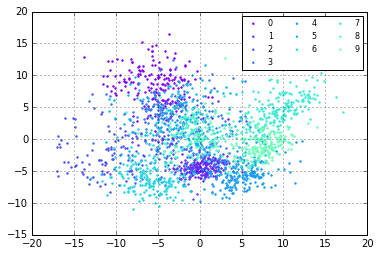

In [31]:
res = w_sum_fc2.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False, keep_prob: 1.0})
pca = PCA(n_components=2)
Y = pca.fit_transform(res)
#tsne = manifold.TSNE(n_components=2, init='pca',metric='euclidean',n_iter=200)
#Y = tsne.fit_transform(res)
#Y = Y.tolist()
print Y.shape
plts = []
for idx in range(0, n_class):
    plts.append(plt.scatter(Y[locIdx[idx],0], Y[locIdx[idx],1], color=colors[idx], s = 2))
    

plt.grid(True)
plt.legend((plts[0], plts[1], plts[2], plts[3], plts[4], plts[5], plts[6], plts[7], plts[8], plts[9]),
       ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'),
       scatterpoints=1,
       loc='upper right',
       ncol=3,
       fontsize=8)
plt.show()

In [32]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn import mixture

In [33]:
#color_iter = cm.rainbow(np.linspace(0, 1, 10))
color_iter = cm.rainbow(np.linspace(0, 1, len(locIdx)))
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        #splot.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

180
(10, 2)
[0 1]
[[-0.97116623  1.0895773 ]
 [-2.71855908  3.84383487]]


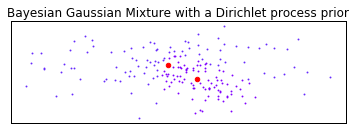

In [36]:
label_num =5
indices = np.where(y_train_s[:]==label_num)[0].tolist()
print len(indices)
# Fit a Dirichlet process Gaussian mixture using five components
'''
dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-5, covariance_prior=1e+2 * np.eye(2),
    init_params="random", max_iter=1000, random_state=11).fit(Y[indices])
plot_results(Y[indices], dpgmm.predict(Y[indices]), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')
'''

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-5,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-4, covariance_prior=1e+1 * np.eye(2),
    init_params="random", max_iter=1000, random_state=11).fit(Y[indices])
plot_results(Y[indices], dpgmm.predict(Y[indices]), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')
print dpgmm.means_.shape
cluster_idx = np.unique(dpgmm.predict(Y[indices]))
cluster_means = dpgmm.means_[cluster_idx]
print cluster_idx
print cluster_means

plt.scatter(cluster_means[:,0], cluster_means[:,1], color='red')
plt.show()

In [38]:
len(cluster_idx)

2